In [1]:
import sys
sys.path.insert(0,'..')
# sys.path.insert(0,'../../WobbleSim')
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import lax
from jax import jit
from functools import partial

In [2]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [3]:
# x = np.linspace(0,3)
# y = np.ones(x.shape)
# y -= gaussian(x,1.5,1/16)

# x_grid = np.linspace(1,2,500)
# y_grid = lin_interp(x_grid,x,y)

In [4]:
@partial(jit,static_argnames='a')
def lanczos(x,a):
    return jnp.where(jnp.abs(x) < a, 
                     jnp.sinc(jnp.pi*x) * jnp.sinc(jnp.pi*x/a), 0)

In [5]:
def alpha_recursion(i,j,p):
    # fixed values
    if i < 0 or i > p:
        return 0
    if j < 0 or j > p:
        return 0
    if p == 0:
        return 1
    # recursion
    return  (j/p) * alpha_recursion(i,j,p-1) +\
            (1/p) * alpha_recursion(i-1,j,p-1) +\
            ((p+1-j)/p) * alpha_recursion(i,j-1,p-1) -\
            (1/p) * alpha_recursion(i-1,j-1,p-1)

In [6]:
class BSpline:
    def __init__(self,p):
        # calculate coefficients of basis spline functions(piecewise polynomial)
        # p piecewise functions with p+1 terms
#         p = p.astype(int)
        p = int(p)
        self.p = p
        self.alphas = np.zeros((p+1,p+1))
        for i in range(p+1):
            for j in range(p+1):
                self.alphas[i,j] = alpha_recursion(i,j,p)
        self.alphas = jnp.array(self.alphas)
        
    @partial(jit,static_argnums=[0])
    def __call__(self,x,*args):
        # Recentering 
        i = jnp.floor(x + (self.p+1) / 2).astype(int)
        cond1 = i >= 0
        cond2 = i <= self.p
        f = jnp.where((cond1 * cond2), \
                      jnp.polyval(self.alphas[::-1,i], (x + (self.p+1) / 2) % 1), \
                      0.0)
        return f

In [7]:
from matplotlib.colors import LogNorm

In [47]:
def _design_matrix(x,xp,dx,basis,a):
    '''
        Internal Function for general_interp_simple
        to do: 
        make sparse using 'a' and fast
        choose fast sparse encoding
        the fastest for lstsq solve
        time all
    '''
    
    return basis((x[None,:] - xp[:,None])/dx)

In [82]:
import jax.experimental.sparse

In [146]:
def _sparse_design_matrix(x,xp,dx,basis,a):
    i = jnp.clip(jnp.searchsorted(xp, x,side='right'), 1, len(xp) - 1)

    a_width = np.arange(-a-1,a+1,step=1,dtype=int)
    deltas = (x - xp[i])/dx
    eval_pts = deltas[None,:] + a_width[:,None]
    print(deltas.shape,x.shape,xp.shape,eval_pts)
    eval_pts = eval_pts.flatten()
    print(eval_pts)
#     print(np.min(deltas),np.max(deltas))
    shape = (len(a_width, len(deltas))
    indices = (i[None,:] + a_width[:,None]).flatten()
    ind_bel = jnp.where(indices < 0)
    ind_abv = jnp.where(ind_bel > x.shape[0]-1)
    
#     print(ind_new.shape)
    data = basis(eval_pts[ind_bel * ind_abv])

    temp = np.arange(0,len(x),dtype=int)
    
    indices = np.stack((i,temp)).T.astype(int)
    matrix = jax.experimental.sparse.BCOO((data,indices),shape=(len(xp),len(x)))
    return matrix

In [176]:
# @partial(jit,static_argnames=['basis','a'])
def general_interp_sparse(x, xp, ap, basis, a):
    '''
        XP must be equally spaced
        deal boundary conditions 0D, 0N
        padding points
        with user inputs values

        for future test for a, where basis function goes to zero
    '''
    ap = jnp.array(ap)
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    design = _sparse_design_matrix(x,xp,dx,basis,a)
    print(design.shape,ap.shape)
    
    # THIS IS NOT POSSIBLE YET BC SPARSE has not been handled to
    return jnp.einsum('ij,i->j', design, ap)


@partial(jit,static_argnames=['basis','a'])
def general_interp_loose(x, xp, ap, basis, a):
    '''XP must be equally spaced
    deal boundary conditions 0D, 0N
    padding points
    with user inputs values
    
    for future test for a, where basis function goes to zero'''
    dx = xp[1] - xp[0]# GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    
    return _design_matrix(x,xp,dx,basis,a).T @ ap

In [177]:
bspline_order = 3
lin_spline    = BSpline(bspline_order)

In [186]:
dx = 0.1
x = np.arange(0,3,step=dx)
y = np.zeros(x.shape)
y -= gaussian(x,1.5,1/8)
y -= np.random.normal(0,1/200,size=y.shape[0])
# y[:] = 0.88

x_grid = np.linspace(0,3,1000)
y_grid  = general_interp_loose(x_grid,x,y,basis=lin_spline,a=bspline_order)
y2_grid = general_interp_sparse(x_grid,x,y,basis=lin_spline,a=bspline_order)

(1000,) (1000,) (30,)
(1000,) (1000,) int32
(30, 1000) (30,)


TypeError: Value DynamicJaxprTracer[BCOO(float32[30, 1000], nse=1000)] with type <class 'jax.experimental.sparse.bcoo.BCOO'> is not a valid JAX type

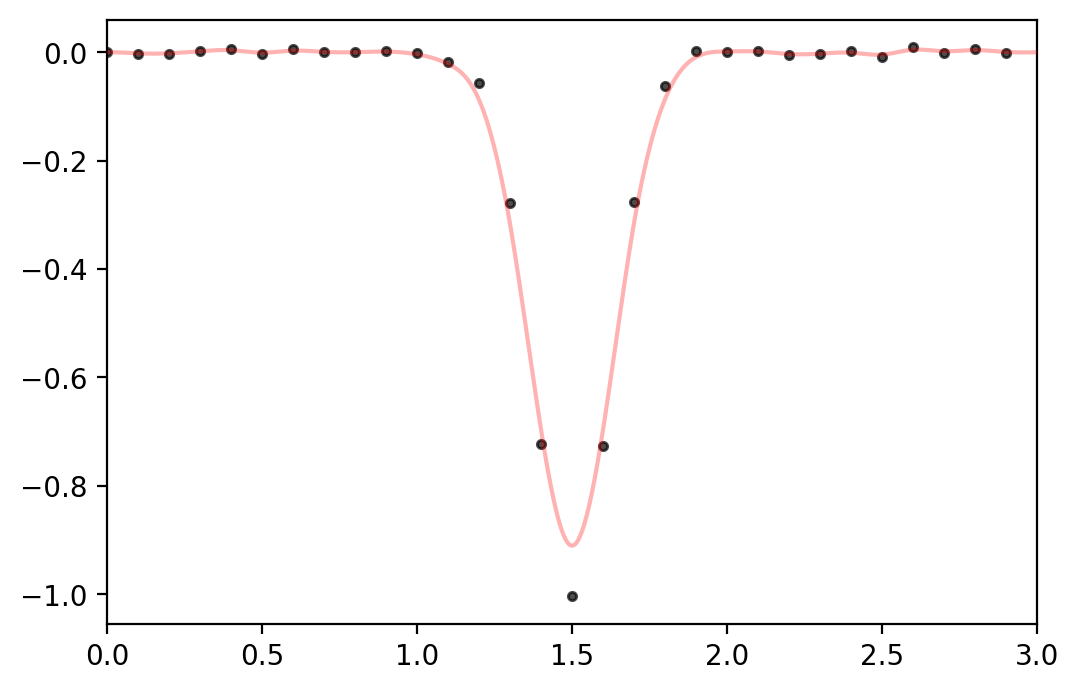

In [187]:
plt.figure(facecolor=(1,1,1),dpi=200)
plt.plot(x,y,'.k',alpha=0.7)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
# plt.plot(x_grid,y2_grid,'-b',alpha=0.3,zorder=3)
plt.xlim(0,3)
plt.savefig('../out/bspline{}_interp.png'.format(bspline_order))
plt.show()

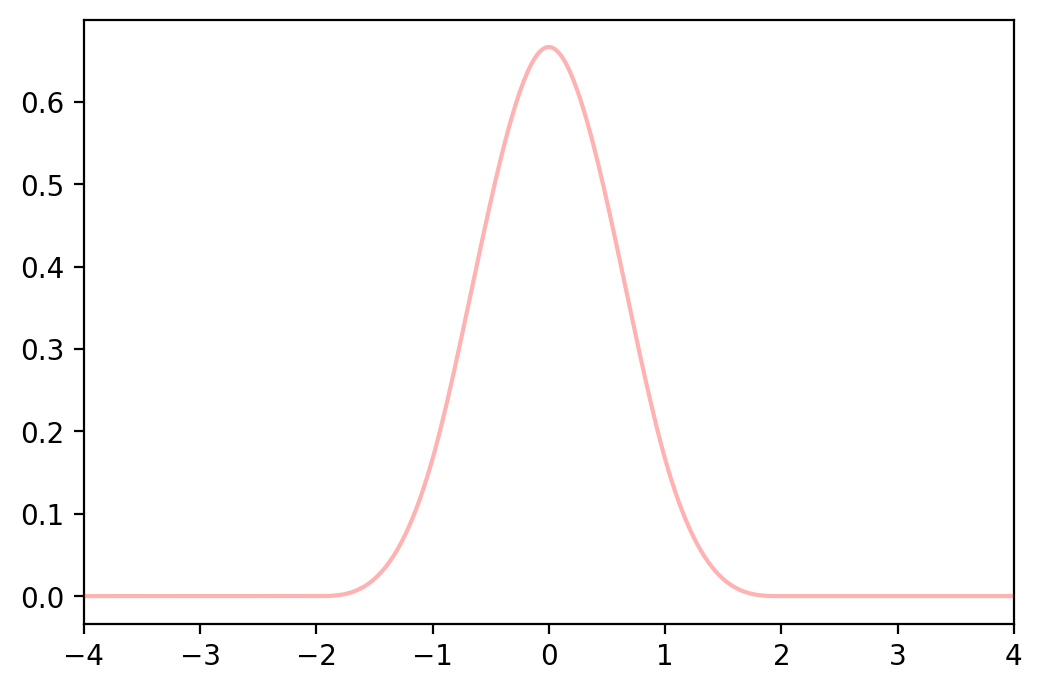

In [180]:
x_grid = np.linspace(-4,4,500)
y_grid = lin_spline(x_grid)
plt.figure(facecolor=(1,1,1),dpi=200)
plt.plot(x_grid,y_grid,'-r',alpha=0.3,zorder=3)
plt.xlim(-4,4)
plt.savefig('../out/bspline{}_kernel.png'.format(bspline_order))
plt.show()

In [15]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [16]:
import jabble.dataset
import jabble.loss
import jabble.model

import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const

In [17]:
resolution = 120_000
snr        = 100
epoches    = 20

dx = jabble.dataset.delta_x(resolution)
dl = 4540/resolution
print(dx,dl)
wave_grid = np.arange(4538,4545,step=dl) * u.Angstrom
x_grid    = np.log(wave_grid.to(u.Angstrom).value)

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-5,5,epoches) * u.km/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

print(shifts)

stellar_peaks = [np.log(4541.5),np.log(4542),np.log(4542.5)]
flux = np.ones((epoches,*wave_grid.shape))
# print(type(x_grid),type(mean),type(shifts))
for mean in stellar_peaks:
    flux -= 0.7 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),\
                 np.repeat((mean + shifts)[:,np.newaxis],wave_grid.shape[0],axis=1),dx)
    
tellurics_peaks = [np.log(4539)]
for mean in tellurics_peaks:
    flux -= 0.7 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),\
                 np.repeat(mean[np.newaxis,np.newaxis],wave_grid.shape[0],axis=1),dx)
    
# add noise
for j in range(flux.shape[0]):
    for k in range(flux.shape[1]):
        flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))
ferr = flux/snr

8.333298611358605e-06 0.03783333333333333
[-2.16816665e-04 -1.93993858e-04 -1.71171051e-04 -1.48348243e-04
 -1.25525436e-04 -1.02702630e-04 -7.98798230e-05 -5.70570163e-05
 -3.42342098e-05 -1.14114033e-05  1.14114033e-05  3.42342098e-05
  5.70570163e-05  7.98798230e-05  1.02702630e-04  1.25525436e-04
  1.48348243e-04  1.71171051e-04  1.93993858e-04  2.16816665e-04]


In [18]:
dataset = jabble.dataset.Dataset.from_flux(np.repeat((wave_grid)[np.newaxis,:],epoches,axis=0),flux,ferr,mask=np.ones(flux.shape))

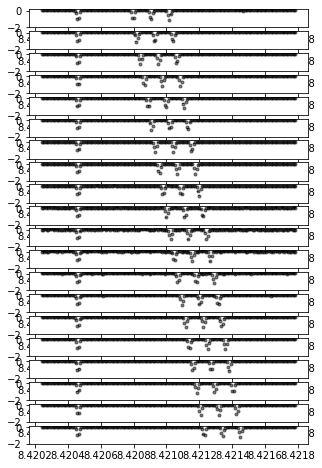

In [19]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(plt_inds,figsize=(5,8))
for ele in range(plt_inds):
    axes[ele].errorbar(dataset.xs[ele,:],dataset.ys[ele,:],dataset.yerr[ele,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[ele].set_ylim(-2,0.2)
plt.show() 

In [20]:
type(dataset.xs), type(dataset.ys), type(dataset.mask), type(dataset.yivar)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [21]:
loss = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [22]:
class BSplineModel(jabble.model.Model):
    def __init__(self,xs,p_val=2,p=None):
        super(BSplineModel,self).__init__()
        # when defining ones own model, need to include inputs as xs, outputs as ys
        # and __call__ function that gets ya ther, and params (1d ndarray MUST BE BY SCIPY) to be fit
        # also assumes epoches of data that is shifted between
        self.spline = BSpline(p_val)
        self.p_val = p_val
        self.xs = xs
        if p is not None:
            if p.shape == self.xs.shape:
                self.p = p
            else:
                logging.error('p {} must be the same shape as x_grid {}'.format(p.shape,xs.shape))
        else:
            self.p = np.zeros(xs.shape)

    def call(self,p,x,i):
        # print()
        # print(p.shape)
        y = general_interp_loose(x, self.xs, p, basis=self.spline, a=self.p_val//2)
        return y

In [23]:
class MyModel(BSplineModel):
    def __init__(self,*args,**kwargs):
        super(MyModel,self).__init__(*args,**kwargs)
        self.p_i = None
    
    
    def split_p(self,p,*args):
        if len(p) !=  0:
            self.p = p
    
    def fit(self):
        self.p_i  = None
        self._fit = True
    
    def fix(self):
        self.p_i  = None
        self._fit = False
        
        
    def fit_p(self,p_i):
        self.p_i  = p_i
        self._fit = True
        
    def get_parameters(self):
        if self._fit:
            if self.p_i is not None:
                return jnp.array(self.p[self.p_i])
            return jnp.array(self.p)
        else:
            return jnp.array([])
        
    def unpack(self,p):
        if len(p) != 0:
            if self.p_i is not None:
                self.p[self.p_i] = p
            else:
                self.p = p
        
        
    def __call__(self,p,*args):
#         print('on call')
        # if there are no parameters coming in, then use the stored parameters
        if len(p) == 0:
            assert self._fit == False
            return self.call(self.p,*args)
        else:
            assert self._fit == True
            if self.p_i is not None:
                return self.call(jnp.array(self.p).at[self.p_i].set(p),*args)
            return self.call(p,*args)

In [24]:
vel_padding = 100 * u.km/u.s
bspline_order = 4
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
model_list = []
for i in range(1,bspline_order):
    model_list.append(jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),MyModel(model_grid,p_val=i)]))
# stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),BSplineModel(model_grid,p_val=bspline_order)])

In [25]:
def train_cycle(model,dataset,loss):
    options = {"maxiter":15000,'maxls':256,'ftol':1e-60,'gtol':1e-35,'tol':1e-30,'eps':1e-60}
    options_2 = {}
    
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    model.fit(1)
    res1 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res1['message'],res1['nit'])
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    model.fit(0)
    res2 = model.optimize(loss,dataset,options=options,verbose=False)
    print(res2['message'],res2['nit'])
    
#     # Fitting Round 3
#     print('fitting round 3')
#     model.fix()
#     model.fit(1)
#     res3 = model.optimize(loss,dataset,method='Newton-CG',options=options_2,verbose=False)
#     print(res3['message'],res3['nit'])
    
    # Fitting Round 4
#     vel_grid   = np.linspace(-6,6,200) * u.km/u.s
#     shift_grid = jabble.dataset.shifts(vel_grid)[None,:] * np.ones(epoches)[:,None]
#     loss_array = model[0].grid_search(shift_grid,loss,model,dataset)
#     x_min      = jabble.dataset.get_parabolic_min(loss_array,shift_grid)
#     model[0].p = x_min
    
    # Fitting Round 5
    print('fitting round 5')
    model.fix()
    model.fit(0)
    model.fit(1)
    res5 = model.optimize(loss,dataset,options=options,verbose=True)
    print(res5['message'],res5['nit'])
    
    # Fitting Round 6
    print('fitting round 6')
    options = {'maxiter': 256, 'size': 1e-20, 'condition': 1e10}
    model.fix()
    model.fit(1)
    res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
    print('fitting round 7')
    model.fix()
#     model.fit(0)
    model.fit(1)
    res5 = model.optimize(loss,dataset,options=options,verbose=True)
    print(res5['message'],res5['nit'])
    
    vel_grid   = np.linspace(-500,500,500) * u.m/u.s
    shift_grid = jabble.dataset.shifts(vel_grid)[None,:] + model[0].p[:,None]
    loss_array = model[0].grid_search(shift_grid,loss,model,dataset)
    x_min      = jabble.dataset.get_parabolic_min(loss_array,shift_grid)
    model[0].p = x_min
    
    # Fitting Round 8
    print('fitting round 8')
    options = {'maxiter': 256, 'size': 1e-20, 'condition': 1e10}
    model.fix()
    model.fit(1)
    res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
    # Round 9
    print('fitting round 9')
    model.fix()
#     model.fit(0)
    model.fit(1)
    res5 = model.optimize(loss,dataset,options=options,verbose=True)
    print(res5['message'],res5['nit'])
    return model

In [26]:
# model_list[0].split_p(model_list[0].get_parameters())
# model_list[0].display()

In [27]:
for model in model_list:
    model = train_cycle(model,dataset,loss)

fitting round 1


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 15
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 9
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 2
fitting round 4
118


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 5


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 6


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 1
fitting round 1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 16
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 6
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 1
fitting round 4
87


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 5


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 6


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 1
fitting round 1
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 18
fitting round 2
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 6
fitting round 3
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 1
fitting round 4
80


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 5


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: maxls, ftol, tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


Desired error not necessarily achieved due to precision loss. 0
fitting round 6


/home/mdd423/wobble_jax/notebooks/../jabble/model.py:102: OptimizeWarning: Unknown solver options: tol
  res = scipy.optimize.minimize(val_gradient_function, self.get_parameters(), jac=True,


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 1


In [28]:
from matplotlib import cm

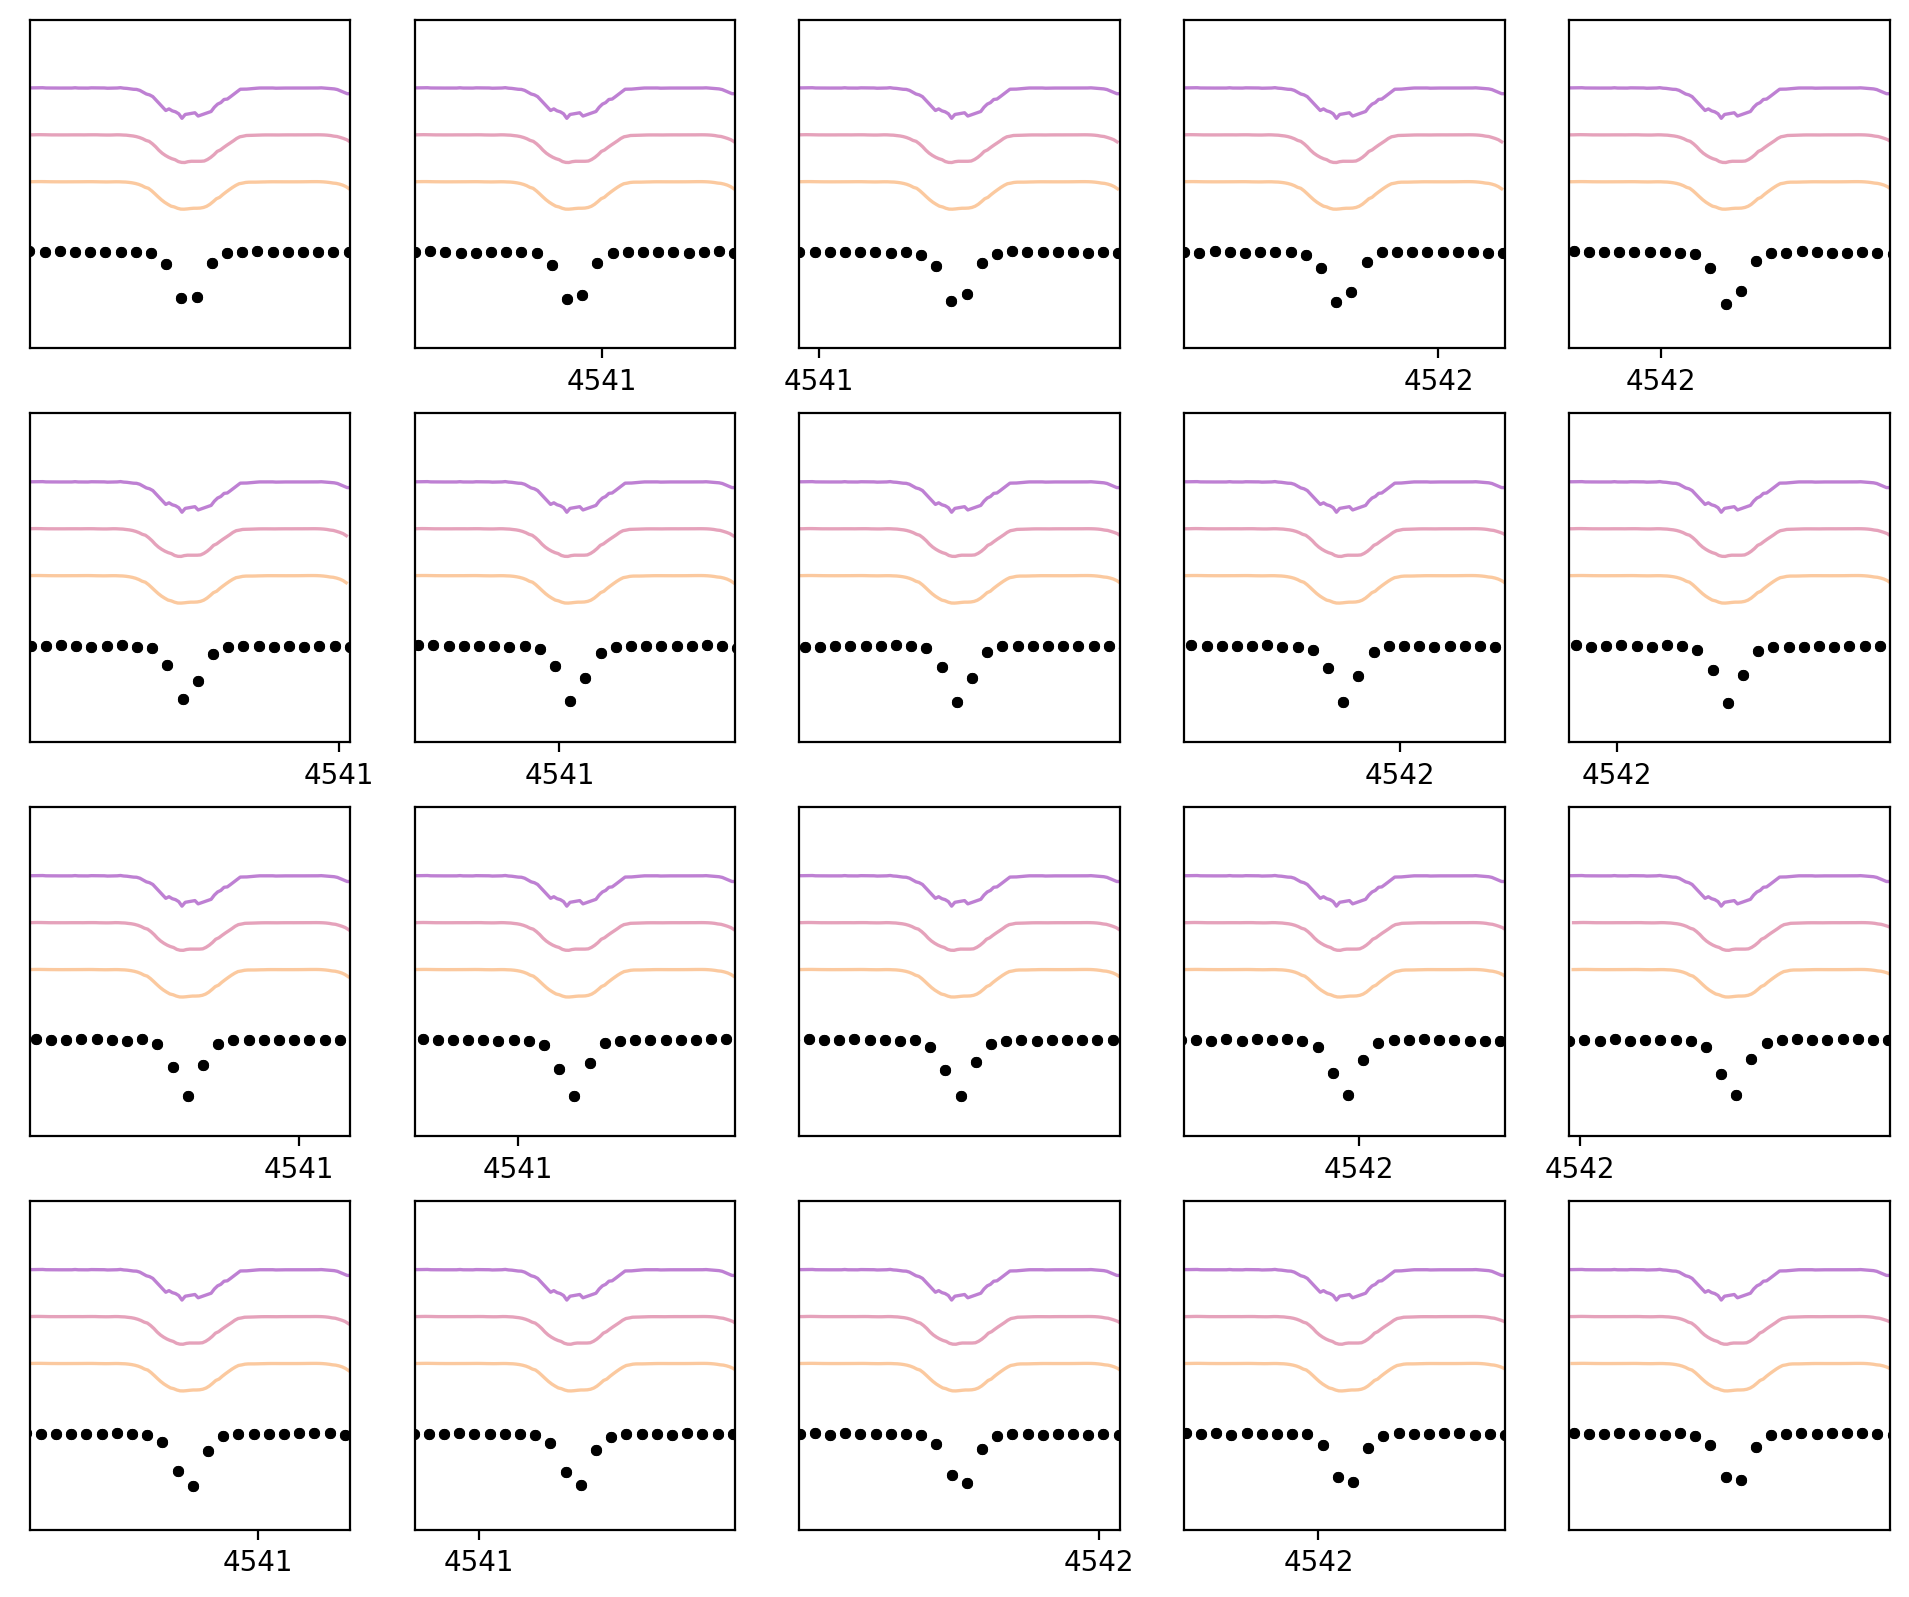

In [29]:
lmin = 4540
lmax = 4543.5
x_window = np.log(4550.9) - np.log(4550.5)

lrange = np.arange(lmin,lmax,1)
# plt_unit = u.Angstrom
plt_epoch = 20
n_rows = 4
fig, axes = plt.subplots(n_rows,5,figsize=(12,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
y_shift = 0.5

mean = stellar_peaks[0]
for i,stellar_model in enumerate(reversed(model_list)):
    y_shift += 1.0
# stellar_model = model_list[0]
    for j in range(plt_epoch):
        #         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
        #     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
        axes[j%n_rows, j//n_rows].errorbar(dataset.xs[j,:],dataset.ys[j,:],\
                                 dataset.yerr[j,:],fmt='.k',\
                                 elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
        x_range = np.linspace(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j],100)
        stellar_model.fix()
        colour = cm.plasma((stellar_model[1].p_val)/np.max(bspline_order))
        axes[j%n_rows, j//n_rows].plot(x_range,\
                             y_shift+ stellar_model([],x_range,j),\
                                       color=colour,linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)


        axes[j%n_rows, j//n_rows].set_ylim(-2,5)
        axes[j%n_rows, j//n_rows].set_yticks([])

        axes[j%n_rows, j//n_rows].set_xticks(np.log(lrange))
        axes[j%n_rows, j//n_rows].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[j%n_rows, j//n_rows].set_xlim(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j])

#         res_ax = axes[j%n_rows, j//n_rows].twinx()
#         res_ax.set_yticks([])
#         #     res_ax = axes[j%2,j//2].twinx()
#         #     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
#         #     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
#         res_ax.step(stellar_model[1].xs+stellar_model[0].p[j],\
#                     stellar_model.results[-1]['jac'][stellar_model[0].p.shape[0]:],\
#                     where='mid',alpha=0.1,label='residual',zorder=-1,color=colour)


#         res_ax.set_xlim(xpmin,xpmax)
#         res_ax.set_ylim(-2e3,1e4)
    
plt.savefig(os.path.join(out_dir,'51-allplots-bspline{}.png'.format(bspline_order)),dpi=300,bbox_inches='tight')
plt.show()

In [30]:
for res in stellar_model.results:
    print(res['nit'],res['nfev'],res['message'])
#     print(res['hess_inv'])

15 27 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
9 42 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
2 35 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
0 77 Desired error not necessarily achieved due to precision loss.
0 77 Desired error not necessarily achieved due to precision loss.
1 31 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [31]:
std_rv = np.zeros((len(model_list),epoches)) * u.m/u.s
std_dx = np.zeros(std_rv.shape)
info_dx= np.zeros(std_rv.shape)
for i,stellar_model in enumerate(model_list):
    stellar_model.fix()
    stellar_model.fit(0)
    for j in range(epoches):
        parameters = stellar_model.get_parameters()
        def dummy_function(x):
            return stellar_model(x,dataset.xs[j,:],j)
        deltaj = np.zeros(parameters.shape)
        deltaj[j] = 1

        y, dy  = jax.jvp(dummy_function,(parameters,),(deltaj,))

        info_dx[i,j] = jnp.dot(dy, jnp.multiply(dataset.yivar[j,:], dy))
        std_dx[i,j] = np.sqrt(1/info_dx[i,j])
        std_rv[i,j] = const.c * std_dx[i,j]
#         print(np.mean(std_rv[i,j]))

In [32]:
@jnp.vectorize
def jvelocities(shifts):
    '''
    where c = 1
    '''
    expon = jnp.exp(2*shifts)
    vel = (expon-1)/(1 + expon)
    return vel

In [33]:
jverr = jax.grad(jvelocities)

In [34]:
def verr(x,dx):
#     x = jabble.dataset.shifts(v)
    expon = np.exp(2*x)
    value = expon / ((np.sqrt( (expon - 1)/(expon + 1) )  ) * (expon + 1)**(2))
    print(np.mean(expon),np.mean(x),np.mean(dx),np.mean(value))
    return 2 * const.c * dx * value

24.681816 24.681817113852627 m / s
30.857327 30.85732852992782 m / s
30.511208 30.511211212377543 m / s


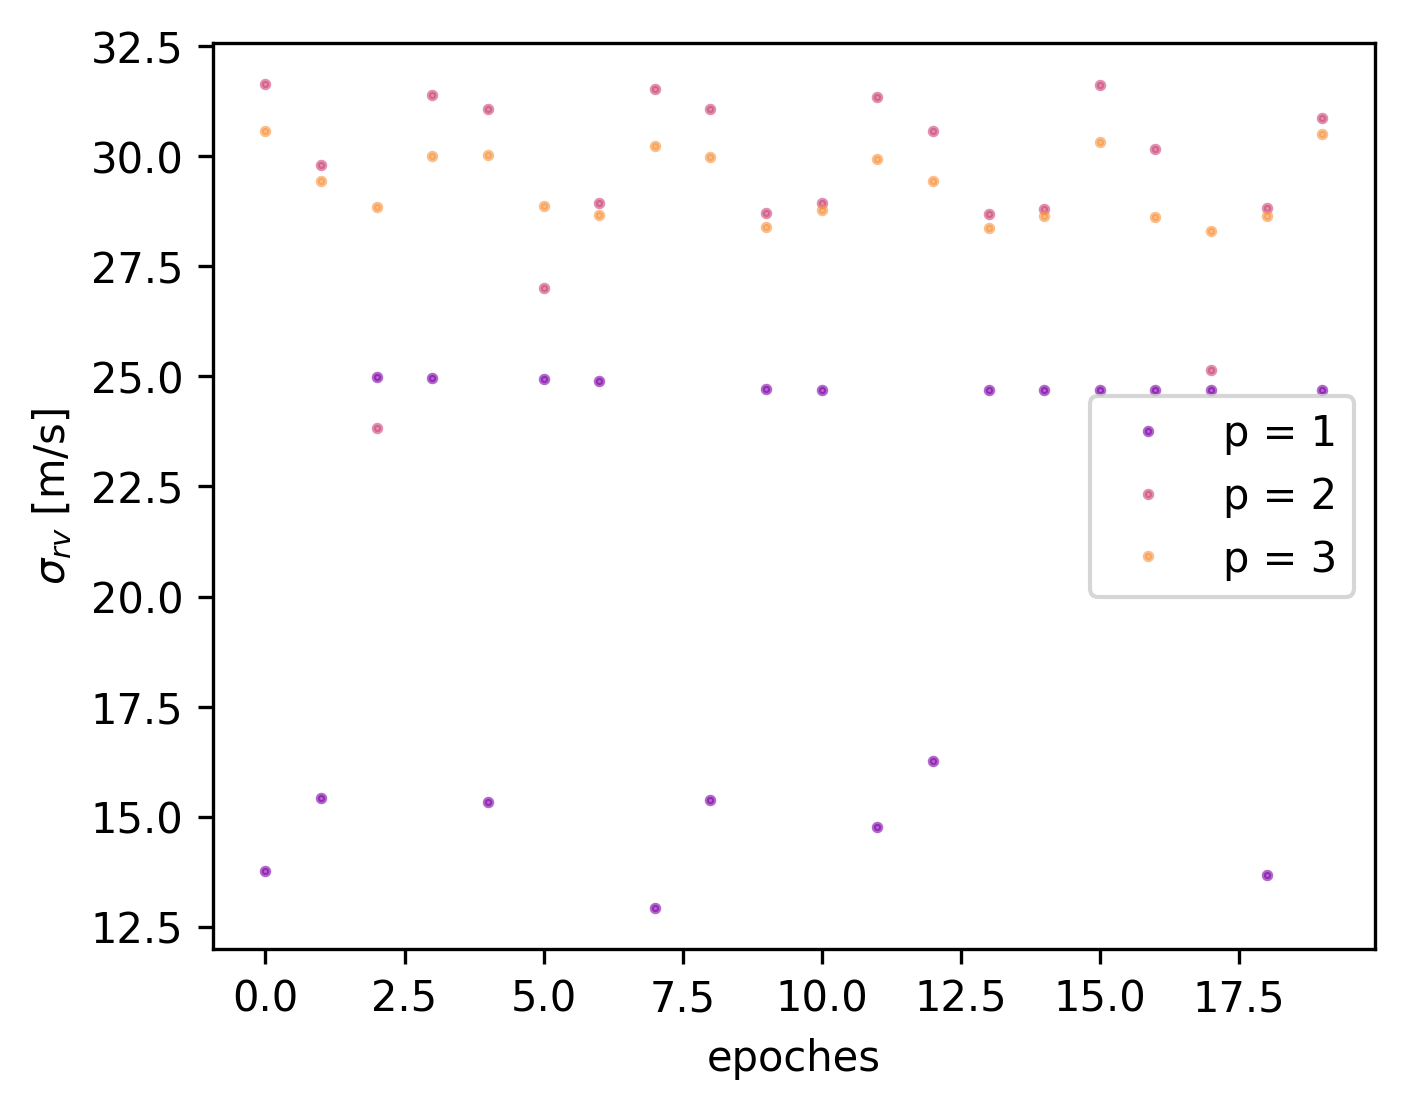

In [35]:
fig,ax = plt.subplots(1,figsize=(5,4),facecolor=(1,1,1),dpi=300)
for i,stellar_model in enumerate(model_list):
    estimate_vel = jabble.dataset.velocities(stellar_model[0].p)
    epoch_range = np.arange(0,epoches,dtype=int)
    colour = cm.plasma((stellar_model[1].p_val)/np.max(bspline_order))
    # ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')
#     ax.hlines([np.sqrt(1/jnp.dot(info_rv[i,:],info_rv[i,:]))],0,epoches,color=colour)
    dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
    ep_index = np.arange(0,len(dv),dtype=int)
    
#     rverr = verr(stellar_model[0].p,std_dx[i,:])
#     jverr_arr = jverr(stellar_model[0].p[j])
#     print(np.mean(jverr_arr))
    
    rverr = [std_dx[i,j] * jverr(stellar_model[0].p[j]) * const.c.to(u.m/u.s).value for j in range(len(stellar_model[0].p))]
    print(rverr[j],std_rv[i,j])
    #     ax.plot(ep_index,dv,'.',label='p = {}'.format(i+1),color=colour,alpha=0.6,markersize=3.5)
    ax.plot(ep_index,rverr,'.',label='p = {}'.format(stellar_model[1].p_val),color=colour,alpha=0.6,markersize=3.5)
    
#     ax.set_ylim(-5.5e3,5.5e3)
#     for epoch in epoch_range:
#         constant = 1e-5
#         ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1]['jac'][epoch])

    # twin_ax = ax.twinx()
    # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
    # twin_ax.set_ylim(-1e9,1e9)
ax.set_ylabel('$\sigma_{rv}$ [m/s]')
plt.xlabel('epoches')
# plt.ylim(-1000,1000)
ax.legend()
plt.savefig(os.path.join(out_dir,'51-sigrv-bspline{}.png'.format(bspline_order)))
plt.show()

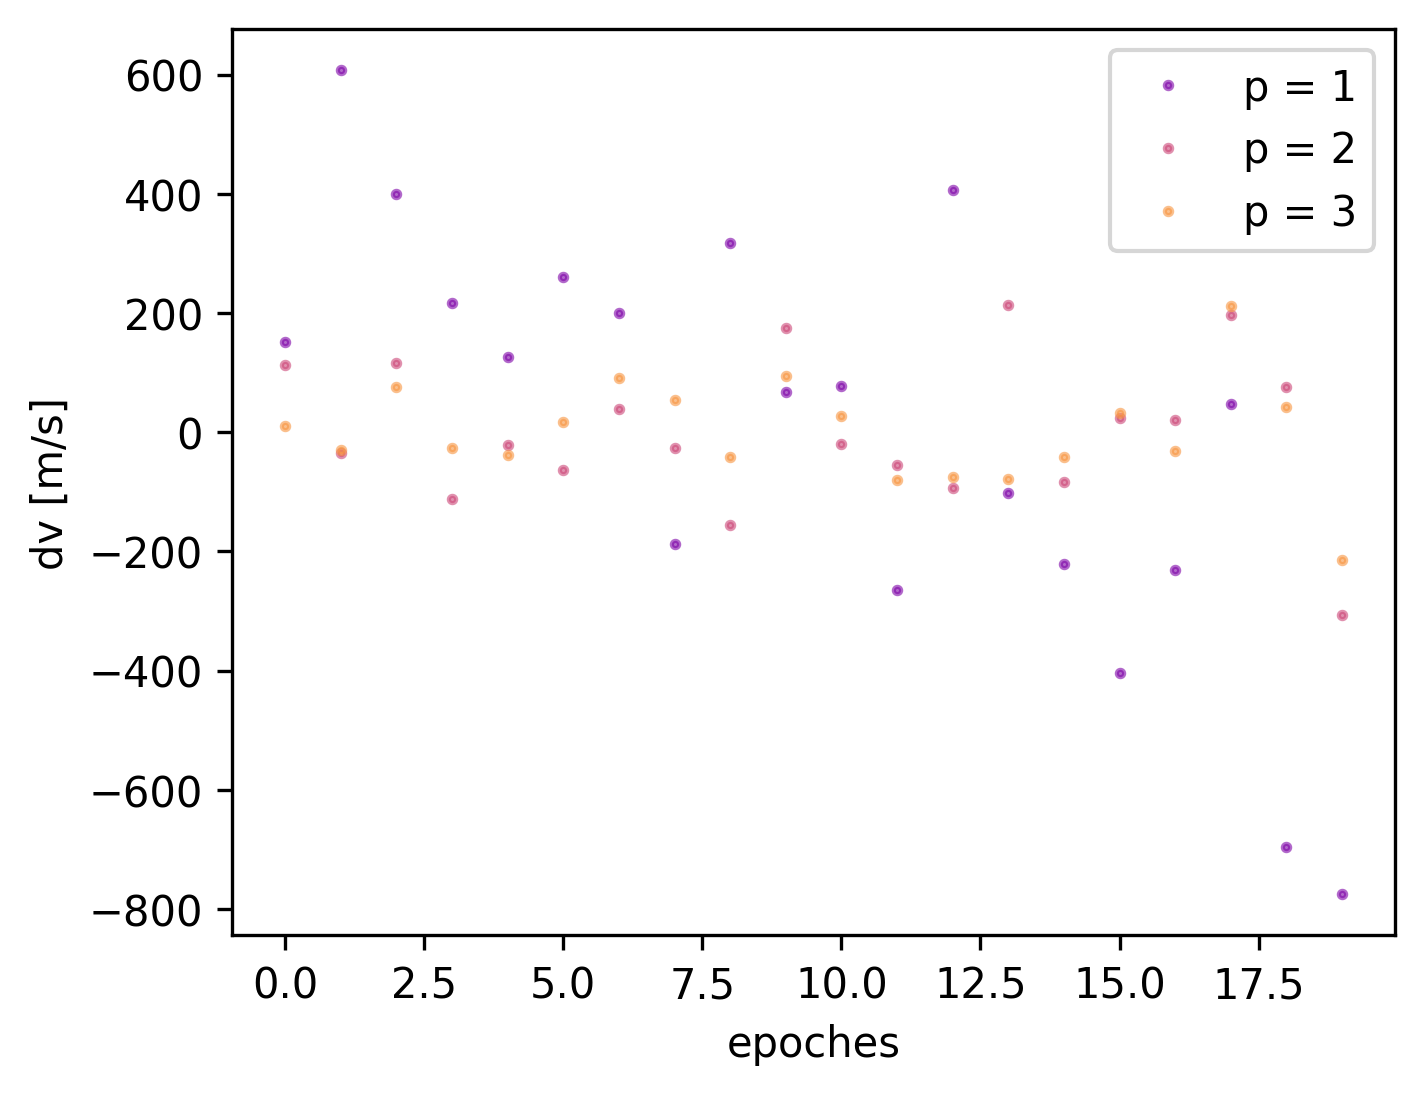

In [36]:
fig,ax = plt.subplots(1,figsize=(5,4),facecolor=(1,1,1),dpi=300)
for i,stellar_model in enumerate(model_list):
    estimate_vel = jabble.dataset.velocities(stellar_model[0].p)
    epoch_range = np.arange(0,epoches,dtype=int)
    colour = cm.plasma((i+1)/np.max(bspline_order))
    # ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')
#     ax.hlines([np.sqrt(1/jnp.dot(info_rv[i,:],info_rv[i,:]))],0,epoches,color=colour)
    dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
    ep_index = np.arange(0,len(dv),dtype=int)
    
#     rverr = verr(stellar_model[0].p,std_dx[i,:])
#     jverr_arr = jverr(stellar_model[0].p[j])
#     print(np.mean(jverr_arr))
    rverr = [std_dx[i,j] * jverr(stellar_model[0].p[j]) * const.c.to(u.m/u.s).value for j in range(len(stellar_model[0].p))]
    ax.plot(ep_index,dv,'.',label='p = {}'.format(i+1),color=colour,alpha=0.6,markersize=3.5)
#     ax.plot(ep_index,rverr,'.',label='p = {}'.format(i+1),color=colour,alpha=0.6,markersize=3.5)
    
#     ax.set_ylim(-5.5e3,5.5e3)
#     for epoch in epoch_range:
#         constant = 1e-5
#         ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1]['jac'][epoch])

    # twin_ax = ax.twinx()
    # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
    # twin_ax.set_ylim(-1e9,1e9)
ax.set_ylabel('dv [m/s]')
plt.xlabel('epoches')
# plt.ylim(-1000,1000)
ax.legend()
plt.savefig(os.path.join(out_dir,'51-dv-bspline{}.png'.format(bspline_order)))
plt.show()

In [37]:
for model in model_list:
    print(np.min(model[0].p),np.max(model[0].p))

-0.00021610951807815056 0.00021443264267873304
-0.00021633505821228605 0.0002158987044822643
-0.00021676061442122468 0.00021612676209765576


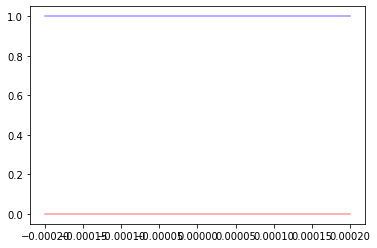

In [38]:
x_range = np.linspace(-0.0002,0.0002,1000)
plt.plot(x_range,jvelocities(x_range),'-r',alpha=0.4)
plt.plot(x_range,[jverr(x) for x in x_range],'-b',alpha=0.4)
plt.show()

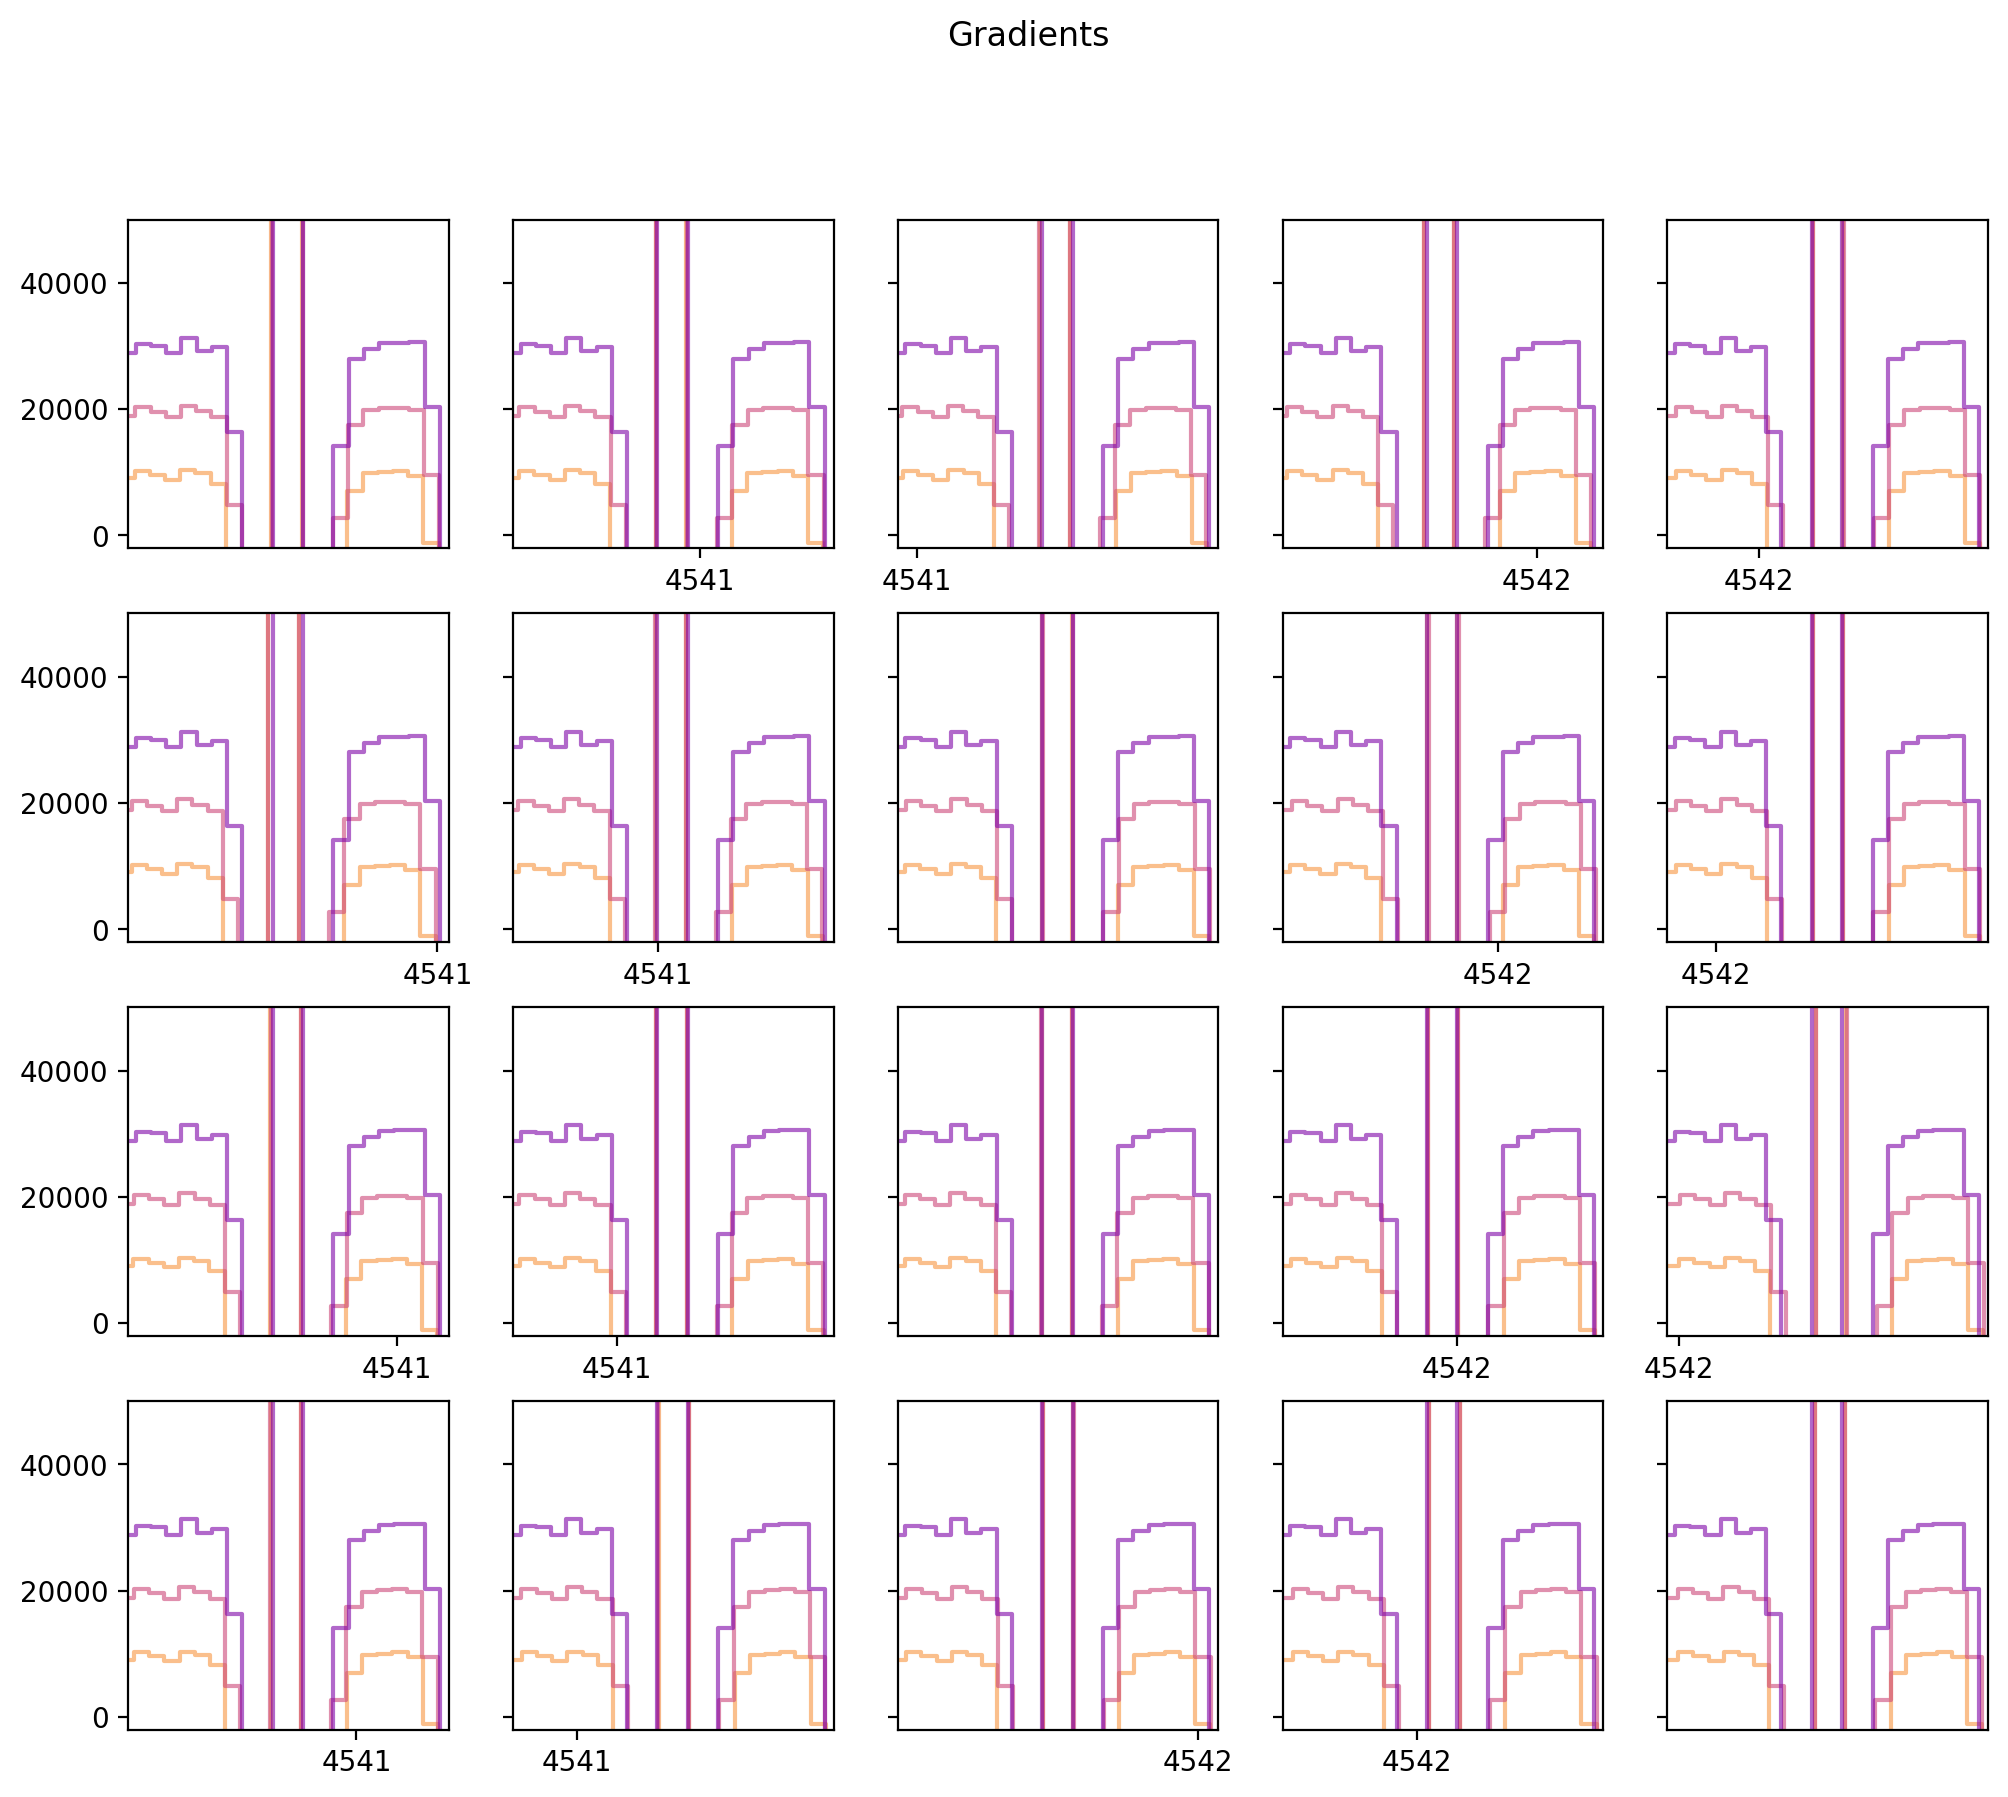

In [39]:
lmin = 4540
lmax = 4543.5
x_window = np.log(4550.9) - np.log(4550.5)

lrange = np.arange(lmin,lmax,1)
# plt_unit = u.Angstrom
plt_epoch = 20
n_rows = 4
fig, axes = plt.subplots(n_rows,5,figsize=(12,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
y_shift = 0.5

mean = stellar_peaks[0]
for i,stellar_model in enumerate(reversed(model_list)):
    y_shift += 1e4
# stellar_model = model_list[0]
    for j in range(plt_epoch):
        #         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
        #     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
#         axes[j%n_rows, j//n_rows].errorbar(dataset.xs[j,:],dataset.ys[j,:],\
#                                  dataset.yerr[j,:],fmt='.k',\
#                                  elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
#         x_range = np.linspace(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j],1000)
#         stellar_model.fix()
        colour = cm.plasma((stellar_model[1].p_val)/np.max(bspline_order))
#         axes[j%n_rows, j//n_rows].plot(x_range,\
#                              y_shift+ stellar_model([],x_range,j),\
#                                        color=colour,linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)


#         axes[j%n_rows, j//n_rows].set_ylim(-2,5)
#         axes[j%n_rows, j//n_rows].set_yticks([])

        axes[j%n_rows, j//n_rows].set_xticks(np.log(lrange))
        axes[j%n_rows, j//n_rows].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[j%n_rows, j//n_rows].set_xlim(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j])

#         res_ax = axes[j%n_rows, j//n_rows].twinx()
#         axes[j%n_rows, j//n_rows].set_yticks([])
        #     res_ax = axes[j%2,j//2].twinx()
        #     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
        #     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
        axes[j%n_rows, j//n_rows].step(stellar_model[1].xs+stellar_model[0].p[j],\
                    stellar_model.results[-1]['jac'][stellar_model[0].p.shape[0]:] + y_shift,\
                    where='mid',alpha=0.6,label='residual',zorder=-1,color=colour)


#         res_ax.set_xlim(xpmin,xpmax)
        axes[j%n_rows, j//n_rows].set_ylim(-2e3,5e4)
plt.suptitle('Gradients')
plt.savefig(os.path.join(out_dir,'51-grad-bspline{}.png'.format(bspline_order)),dpi=300,bbox_inches='tight')
plt.show()

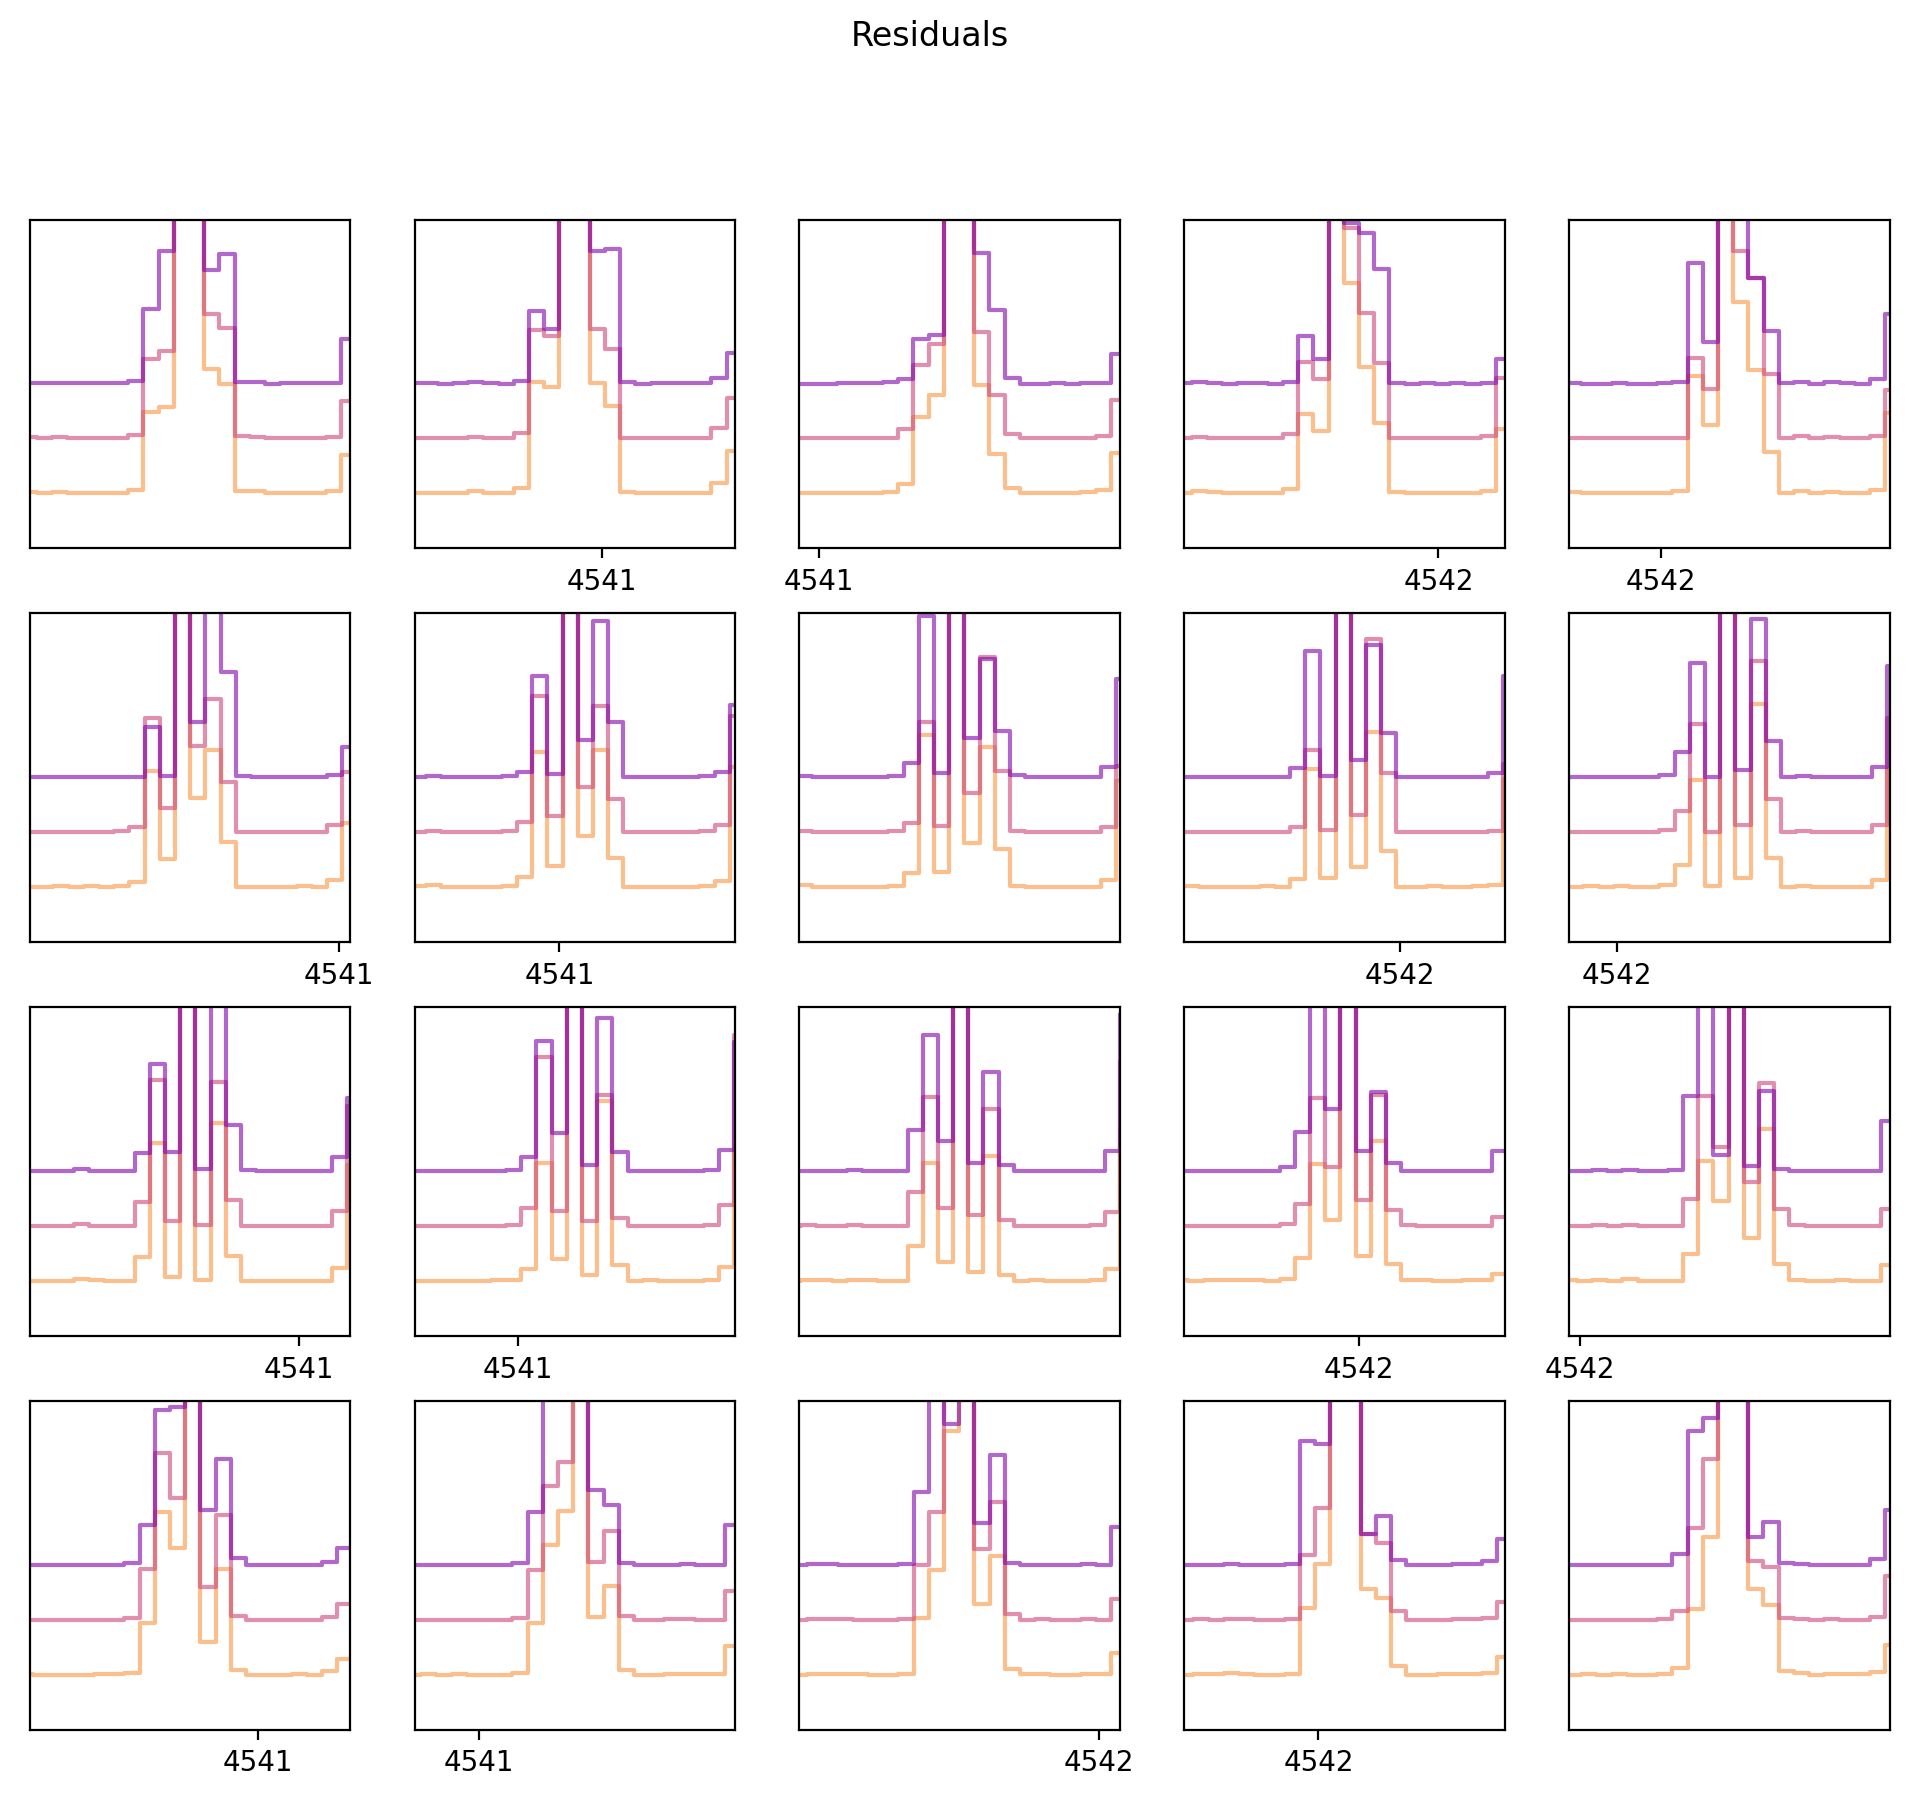

In [40]:
lmin = 4540
lmax = 4543.5
x_window = np.log(4550.9) - np.log(4550.5)

lrange = np.arange(lmin,lmax,1)
# plt_unit = u.Angstrom
plt_epoch = 20
n_rows = 4
fig, axes = plt.subplots(n_rows,5,figsize=(12,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
y_shift = 0.5

mean = stellar_peaks[0]
for i,stellar_model in enumerate(reversed(model_list)):
# stellar_model = model_list[0]
    for j in range(plt_epoch):
        #         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
        #     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
#         axes[j%n_rows, j//n_rows].errorbar(dataset.xs[j,:],dataset.ys[j,:],\
#                                  dataset.yerr[j,:],fmt='.k',\
#                                  elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
#         x_range = np.linspace(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j],1000)
#         stellar_model.fix()
        colour = cm.plasma((stellar_model[1].p_val)/np.max(bspline_order))
#         axes[j%n_rows, j//n_rows].plot(x_range,\
#                              y_shift+ stellar_model([],x_range,j),\
#                                        color=colour,linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)


#         axes[j%n_rows, j//n_rows].set_ylim(-2,5)
        axes[j%n_rows, j//n_rows].set_yticks([])

        axes[j%n_rows, j//n_rows].set_xticks(np.log(lrange))
        axes[j%n_rows, j//n_rows].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[j%n_rows, j//n_rows].set_xlim(mean-x_window+stellar_model[0].p[j],mean+x_window+stellar_model[0].p[j])

#         res_ax = axes[j%n_rows, j//n_rows].twinx()
#         axes[j%n_rows, j//n_rows].set_yticks([])
#         res_ax = axes[j%2,j//2].twinx()
        residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
        axes[j%n_rows, j//n_rows].step(dataset.xs[j,:],residual + y_shift,where='mid',alpha=0.6,label='residual',color=colour)
#         axes[j%n_rows, j//n_rows].step(stellar_model[1].xs+stellar_model[0].p[j],\
#                     stellar_model.results[-1]['jac'][stellar_model[0].p.shape[0]:] + y_shift,\
#                     where='mid',alpha=0.6,label='residual',zorder=-1,color=colour)


#         res_ax.set_xlim(xpmin,xpmax)
        axes[j%n_rows, j//n_rows].set_ylim(-2e2,1e3)
    y_shift += 2e2
plt.suptitle('Residuals')
plt.savefig(os.path.join(out_dir,'51-res-bspline{}.png'.format(bspline_order)),dpi=300,bbox_inches='tight')
plt.show()